In [3]:
import json
import pandas as pd
import numpy as np
import geopandas

from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import requests
from requests.exceptions import HTTPError, RequestException, Timeout

import zipfile
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
URL1 = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'
data = None

try:
    response = requests.get(URL1, timeout=10)
    response.raise_for_status()

except HTTPError as http_err:
    print(f'Erro HTTP: {http_err}')

except ConnectionError as conn_err:
    print(f'Erro de conexão: {conn_err}')

except Timeout as timeout_err:
    print(f'Tempo de resposta excedido: {timeout_err}')

except RequestException as req_err:
    print(f'Erro na requisição: {req_err}')

except Exception as exc:
    print(f'Ocorreu um erro inesperado: {exc}')

else:
    print('Requisição bem-sucedida!')
    data = json.loads(response.text)

Requisição bem-sucedida!


In [5]:
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [6]:
origin_df = pd.json_normalize(deliveries_df['origin'])
origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


In [7]:
deliveries_df['origin'] = pd.DataFrame(deliveries_df['origin'].apply(lambda value: str(value['lat']) + ', ' + str(value['lng'])))
deliveries_df = pd.merge(left=deliveries_df, right=origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"-15.80511751066334, -47.89366206897872",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [8]:
deliveries_df.rename(columns={'lng': 'origin_lng', 'lat': 'origin_lat'}, inplace=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,origin_lng,origin_lat
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"-15.80511751066334, -47.89366206897872",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"-15.83814451122274, -48.05498915846707",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [9]:
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [10]:
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda value: value['size'])).rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda value: value['point']['lng'])).rename(columns={'deliveries': 'destiny_lng'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda value: value['point']['lat'])).rename(columns={'deliveries': 'destiny_lat'}),
], axis=1)

deliveries_normalized_df.head()

,delivery_size,destiny_lng,destiny_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [11]:
deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,origin_lng,origin_lat,delivery_size,destiny_lng,destiny_lat
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,-48.054989,-15.838145,9,-48.116189,-15.848929
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,-48.054989,-15.838145,2,-48.118195,-15.850772
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,-48.054989,-15.838145,1,-48.112483,-15.847871
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,-48.054989,-15.838145,2,-48.118023,-15.846471
0,cvrp-2-df-33,df-2,"-15.83814451122274, -48.05498915846707",180,-48.054989,-15.838145,7,-48.114898,-15.858055


In [12]:
deliveries_df = deliveries_df[['name', 'region', 'origin_lat', 'origin_lng', 'origin', 'vehicle_capacity', 'delivery_size', 'destiny_lat', 'destiny_lng']]
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,origin_lat,origin_lng,origin,vehicle_capacity,delivery_size,destiny_lat,destiny_lng
0,cvrp-2-df-33,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",180,9,-15.848929,-48.116189
1,cvrp-2-df-33,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",180,2,-15.850772,-48.118195
2,cvrp-2-df-33,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",180,1,-15.847871,-48.112483
3,cvrp-2-df-33,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",180,2,-15.846471,-48.118023
4,cvrp-2-df-33,df-2,-15.838145,-48.054989,"-15.83814451122274, -48.05498915846707",180,7,-15.858055,-48.114898


In [13]:
hub_df = deliveries_df[['region', 'origin']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,origin
0,df-0,"-15.657013854445248, -47.802664728268745"
1,df-1,"-15.80511751066334, -47.89366206897872"
2,df-2,"-15.83814451122274, -48.05498915846707"


In [14]:
geolocator = Nominatim(user_agent='geoloc/1.0 (tiicoliro@gmail.com)')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df['geodata'] = hub_df['origin'].apply(geocoder)
hub_df.head()

,region,origin,geodata
0,df-0,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [15]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "origin_town", "address.suburb": "origin_suburb", "address.city": "origin_city"}, inplace=True)
hub_geodata_df["origin_city"] = np.where(hub_geodata_df["origin_city"].notna(), hub_geodata_df["origin_city"], hub_geodata_df["origin_town"])
hub_geodata_df["origin_suburb"] = np.where(hub_geodata_df["origin_suburb"].notna(), hub_geodata_df["origin_suburb"], hub_geodata_df["origin_city"])
hub_geodata_df = hub_geodata_df.drop("origin_town", axis=1)
hub_geodata_df.head()

,origin_suburb,origin_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [16]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "origin_suburb", "origin_city"]]
hub_df.head()

,region,origin_suburb,origin_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [17]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")

In [18]:
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'origin_lat', 'origin_lng', 'origin_suburb', 'origin_city', 'vehicle_capacity', 'delivery_size', 'destiny_lat', 'destiny_lng']]
deliveries_df.head()

,name,region,origin_lat,origin_lng,origin_suburb,origin_city,vehicle_capacity,delivery_size,destiny_lat,destiny_lng
0,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,9,-15.848929,-48.116189
1,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.850772,-48.118195
2,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,1,-15.847871,-48.112483
3,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.846471,-48.118023
4,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,7,-15.858055,-48.114898


In [19]:
deliveries_df['distance_km'] = deliveries_df.apply(lambda row: geodesic((row.origin_lat, row.origin_lng), (row.destiny_lat, row.destiny_lng)).kilometers, axis=1)
deliveries_df['distance_km'] = deliveries_df['distance_km'].round(3)
deliveries_df.head()

,name,region,origin_lat,origin_lng,origin_suburb,origin_city,vehicle_capacity,delivery_size,destiny_lat,destiny_lng,distance_km
0,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,9,-15.848929,-48.116189,6.663
1,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.850772,-48.118195,6.913
2,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,1,-15.847871,-48.112483,6.252
3,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.846471,-48.118023,6.815
4,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,7,-15.858055,-48.114898,6.785


In [20]:
URL2 = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'

try:
    response = requests.get(URL2, timeout=10)
    response.raise_for_status()

except HTTPError as http_err:
    print(f'Erro HTTP: {http_err}')

except ConnectionError as conn_err:
    print(f'Erro de conexão: {conn_err}')

except Timeout as timeout_err:
    print(f'Tempo de resposta excedido: {timeout_err}')

except RequestException as req_err:
    print(f'Erro na requisição: {req_err}')

except Exception as exc:
    print(f'Ocorreu um erro inesperado: {exc}')

else:
    print('Requisição bem-sucedida!')
    
    output_file = 'destiny_geodata.csv'
    with open(output_file, mode='w', encoding='utf-8') as file:
        file.write(response.text)
    
    print(f'Dados salvos com sucesso em {output_file}')


Requisição bem-sucedida!
Dados salvos com sucesso em destiny_geodata.csv


In [21]:
destiny_geodata_df = pd.read_csv('destiny_geodata.csv', sep=',')
destiny_geodata_df.rename(columns={'delivery_city': 'destiny_city', 'delivery_suburb': 'destiny_suburb'}, inplace=True)
destiny_geodata_df.head()

,delivery_lng,delivery_lat,destiny_city,destiny_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [22]:
deliveries_df = pd.merge(left=deliveries_df, right=destiny_geodata_df[['destiny_suburb', 'destiny_city']], how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin_lat,origin_lng,origin_suburb,origin_city,vehicle_capacity,delivery_size,destiny_lat,destiny_lng,distance_km,destiny_suburb,destiny_city
0,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,9,-15.848929,-48.116189,6.663,P Sul,Ceilândia
1,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.850772,-48.118195,6.913,P Sul,Ceilândia
2,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,1,-15.847871,-48.112483,6.252,P Sul,Ceilândia
3,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.846471,-48.118023,6.815,P Sul,Ceilândia
4,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,7,-15.858055,-48.114898,6.785,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [23]:
output_file = 'deliveries_loggi.csv'
deliveries_df.to_csv(output_file, sep=';', index=False)
print(f'Dados salvos com sucesso em {output_file}')

Dados salvos com sucesso em deliveries_loggi.csv


In [24]:
deliveries_df = pd.read_csv('deliveries_loggi.csv', sep=';')
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   origin_lat        636149 non-null  float64
 3   origin_lng        636149 non-null  float64
 4   origin_suburb     636149 non-null  object 
 5   origin_city       636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   destiny_lat       636149 non-null  float64
 9   destiny_lng       636149 non-null  float64
 10  distance_km       636149 non-null  float64
 11  destiny_suburb    476264 non-null  object 
 12  destiny_city      634447 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 63.1+ MB


In [25]:
deliveries_df.isna().any()

name                False
region              False
origin_lat          False
origin_lng          False
origin_suburb       False
origin_city         False
vehicle_capacity    False
delivery_size       False
destiny_lat         False
destiny_lng         False
distance_km         False
destiny_suburb       True
destiny_city         True
dtype: bool

In [26]:
100 * (deliveries_df['destiny_city'].isna().sum() / len(deliveries_df))

np.float64(0.26754738276724477)

In [27]:
100 * (deliveries_df['destiny_suburb'].isna().sum() / len(deliveries_df))

np.float64(25.133262804783158)

In [28]:
prop_df = deliveries_df['destiny_city'].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

destiny_city
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [29]:
prop_df = deliveries_df['destiny_suburb'].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

destiny_suburb
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

In [30]:
URL3 = "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip"
zip_filename = 'distrito-federal.zip'
output_dir ='./maps'

try:
    response = requests.get(URL3, timeout=10)
    response.raise_for_status()

except HTTPError as http_err:
    print(f'Erro HTTP: {http_err}')

except ConnectionError as conn_err:
    print(f'Erro de conexão: {conn_err}')

except Timeout as timeout_err:
    print(f'Tempo de resposta excedido: {timeout_err}')

except RequestException as req_err:
    print(f'Erro na requisição: {req_err}')

except Exception as exc:
    print(f'Ocorreu um erro inesperado: {exc}')

else:
    if not os.path.exists(zip_filename):
        # Baixa o arquivo ZIP
        with open(zip_filename, 'wb') as f:
            f.write(response.content)
        print('Arquivo zip baixado com sucesso.')

            # Cria o diretório de saída, se não existir
        os.makedirs(output_dir, exist_ok=True)

        # Descompacta o arquivo ZIP
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print('Arquivo zip descompactado com sucesso.')
    else:
        print('Arquivo .zip já foi baixado é descompactado')



Erro na requisição: HTTPSConnectionPool(host='geoftp.ibge.gov.br', port=443): Read timed out.


In [31]:
# Caminho dos arquivos de oridem e destino
shp_source = os.path.join(output_dir, 'LIM_Unidade_Federacao_A.shp')
shx_source = os.path.join(output_dir, 'LIM_Unidade_Federacao_A.shx')
shp_destination = 'distrito-federal.shp'
shx_destination = 'distrito-federal.shx'

# Move o arquivo .shp se não existir na pasta atual
if not os.path.exists(shp_destination):
    os.rename(shp_source, shp_destination)
    print('Arquivo .shp movido com sucesso.')
else:
    print('Arquivo .shp já existe na pasta atual.')

# Move o arquivo .shx se não existir na pasta atual
if not os.path.exists(shx_destination):
    os.rename(shx_source, shx_destination)
    print('Arquivo .shx movido com sucesso.')
else:
    print('Arquivo .shx já existe na pastra atual.')

Arquivo .shp já existe na pasta atual.
Arquivo .shx já existe na pastra atual.


In [32]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0, -47.31057 -..."


In [33]:
origin_df = deliveries_df[['region', 'origin_lat', 'origin_lng']].drop_duplicates().reset_index(drop=True)
geo_origin_df =  geopandas.GeoDataFrame(origin_df, geometry=geopandas.points_from_xy(origin_df.origin_lng, origin_df.origin_lat))
geo_origin_df.head()

,region,origin_lat,origin_lng,geometry
0,df-2,-15.838145,-48.054989,POINT (-48.05499 -15.83814)
1,df-1,-15.805118,-47.893662,POINT (-47.89366 -15.80512)
2,df-0,-15.657014,-47.802665,POINT (-47.80266 -15.65701)


In [34]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df.destiny_lng, deliveries_df.destiny_lat))
geo_deliveries_df.head()

,name,region,origin_lat,origin_lng,origin_suburb,origin_city,vehicle_capacity,delivery_size,destiny_lat,destiny_lng,distance_km,destiny_suburb,destiny_city,geometry
0,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,9,-15.848929,-48.116189,6.663,P Sul,Ceilândia,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.850772,-48.118195,6.913,P Sul,Ceilândia,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,1,-15.847871,-48.112483,6.252,P Sul,Ceilândia,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,2,-15.846471,-48.118023,6.815,P Sul,Ceilândia,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-15.838145,-48.054989,Taguatinga,Taguatinga,180,7,-15.858055,-48.114898,6.785,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.1149 -15.85805)


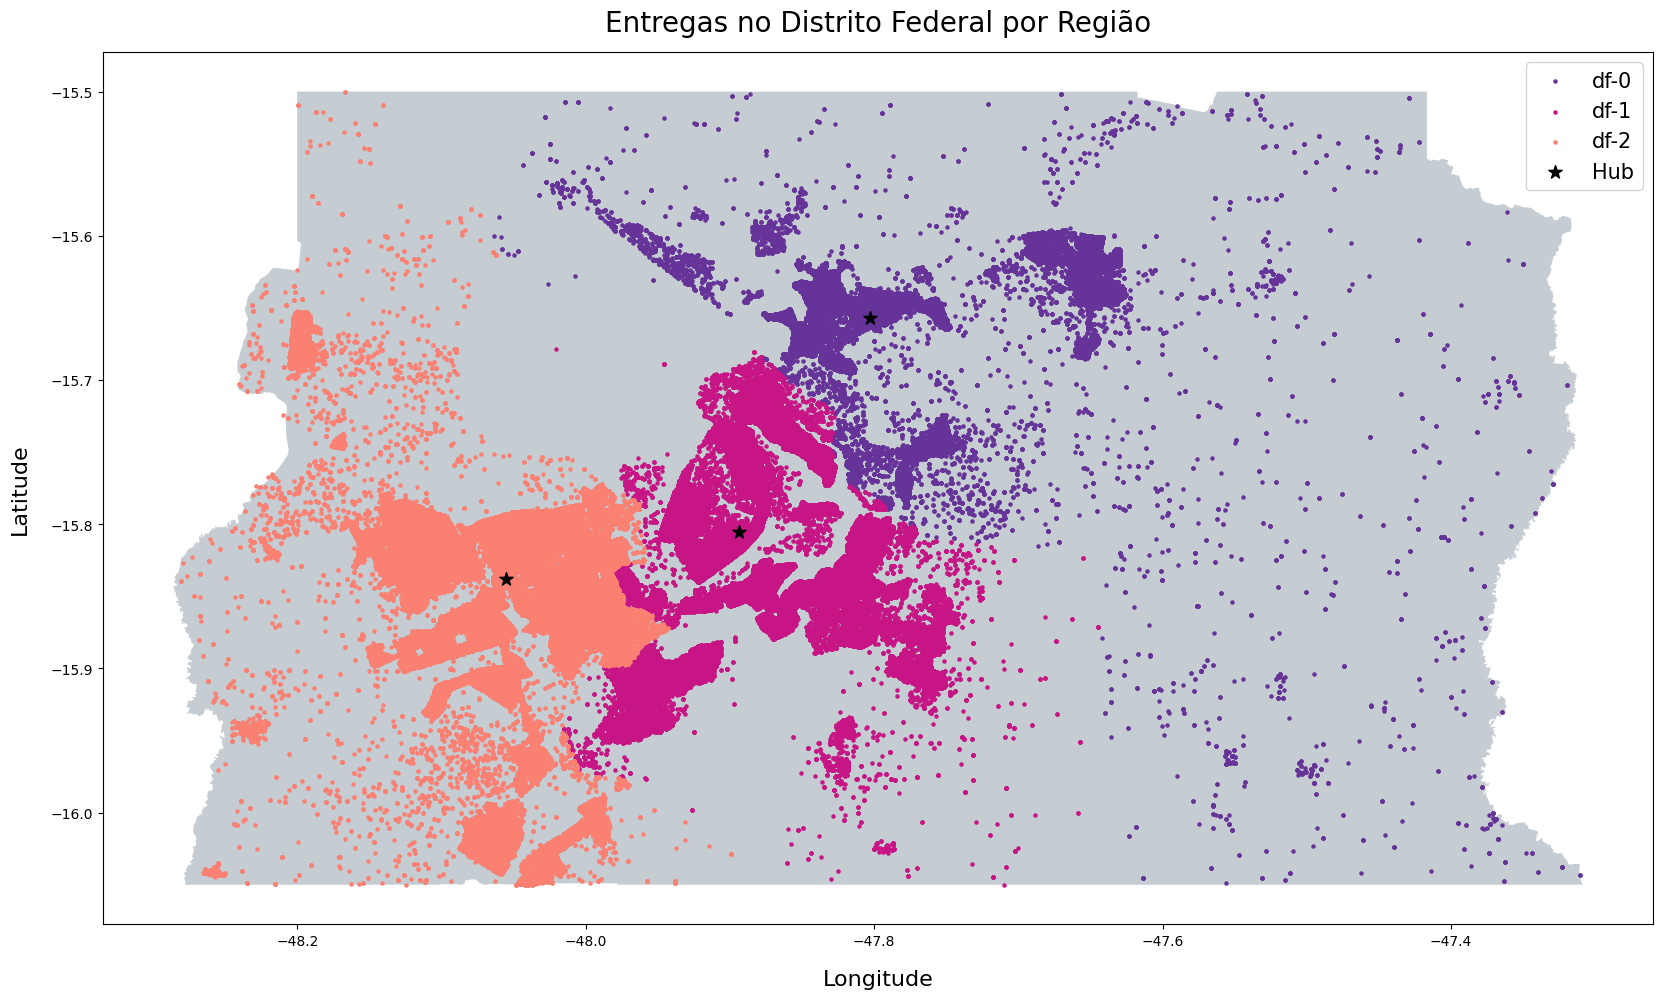

In [47]:
# Cria o plot vazio.
fig, ax = plt.subplots(figsize= (20, 20))

# Plot mapa do Distrito Federal.
mapa.plot(ax=ax, alpha= 0.4, color='slategrey')

# Plot das entregas.
geo_deliveries_df.query('region == "df-0"').plot(ax=ax, markersize=5, color='rebeccapurple', label='df-0')
geo_deliveries_df.query('region == "df-1"').plot(ax=ax, markersize=5, color='mediumvioletred', label='df-1')
geo_deliveries_df.query('region == "df-2"').plot(ax=ax, markersize=5, color='salmon', label='df-2')

# Plot dos hubs.
geo_origin_df.plot(ax=ax, markersize=100, marker='*', color='black', label='Hub')

# Adiciona títulos e rótulos.
plt.title("Entregas no Distrito Federal por Região", fontsize=20, pad=15)
plt.xlabel('Longitude', fontsize=16, labelpad=15)
plt.ylabel('Latitude', fontsize=16, labelpad=15)

# plot da legenda.
plt.legend(prop={"size": 15})

# Exibe o gráfico.
plt.show()

In [50]:
total_deliveries_df = deliveries_df.groupby('region').size().reset_index(name='quantity_deliveries')
total_deliveries_df.head()

,region,quantity_deliveries
0,df-0,70122
1,df-1,304708
2,df-2,261319


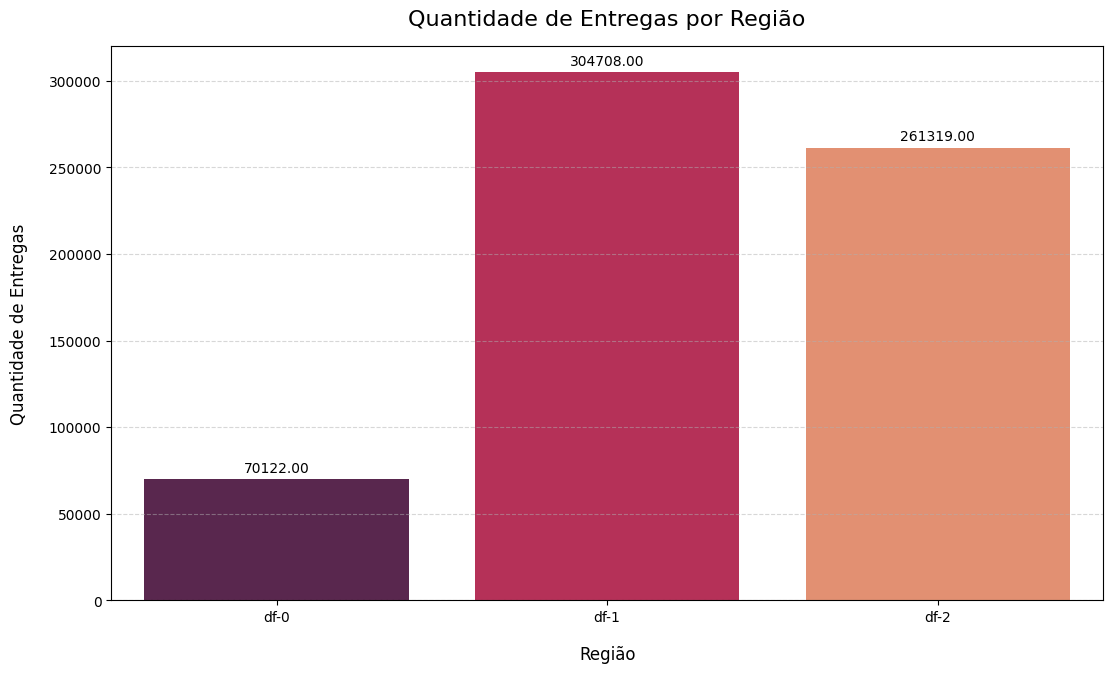

In [97]:
# Define o tamanho da figura.
plt.figure(figsize=(12.8, 7.2))

# Cria o barplot com Seaborn.
bar_plot0 = sns.barplot(data=total_deliveries_df, x='region', y='quantity_deliveries', hue='region', palette='rocket')

# Adiciona valores em cima das colunas.
for p in bar_plot0.containers:
    bar_plot0.bar_label(p, fmt='%.2f', label_type='edge', padding=3)

# Adicionar título e rótulos.
plt.title('Quantidade de Entregas por Região', fontsize=16, pad=15)
plt.xlabel('Região', fontsize=12, labelpad=15)
plt.ylabel('Quantidade de Entregas', fontsize=12, labelpad=15)

# Linhas no gráfico.
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Exibir o gráfico.
plt.show()


In [37]:
region_percent_df = pd.DataFrame(deliveries_df['region'].value_counts(normalize=True)).sort_values('region').reset_index()
region_percent_df.rename(columns={'proportion': "region_percent"}, inplace=True)
region_percent_df.head()

,region,region_percent
0,df-0,0.110229
1,df-1,0.478988
2,df-2,0.410783


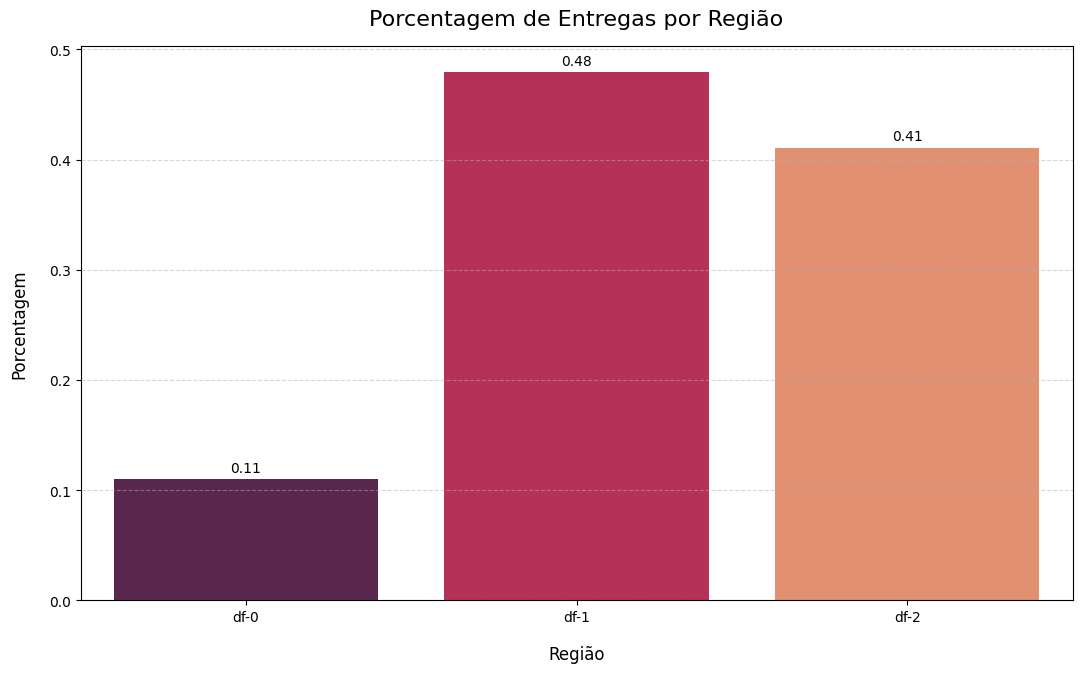

In [90]:
# Define o tamanho da figura
plt.figure(figsize=(12.8, 7.2))

# Cria o barplot com Seaborn
bar_plot1 = sns.barplot(data=region_percent_df, x='region', y='region_percent', hue='region', palette='rocket')

# Adiciona valores em cima das colunas.
for p in bar_plot1.containers:
    bar_plot1.bar_label(p, fmt='%.2f', label_type='edge', padding=3)

# Adicionar título e rótulos
plt.title('Porcentagem de Entregas por Região', fontsize=16, pad=15)
plt.xlabel('Região', fontsize=12, labelpad=15)
plt.ylabel('Porcentagem', fontsize=12, labelpad=15)

# Linhas no gráfico
plt.grid(axis='y', linestyle="--", alpha=0.5)

#exibir gráfico
plt.show()

In [39]:
min_mean_max_df = deliveries_df.groupby('region')['distance_km'].agg(['min', 'mean', 'max']).reset_index()
min_mean_max_long_df = min_mean_max_df.melt(id_vars='region', value_vars=['min', 'mean', 'max'], var_name='measure', value_name='distance')
min_mean_max_df.head()

,region,min,mean,max
0,df-0,0.008,9.017965,67.848
1,df-1,0.003,5.945365,33.500
2,df-2,0.006,7.887435,39.532


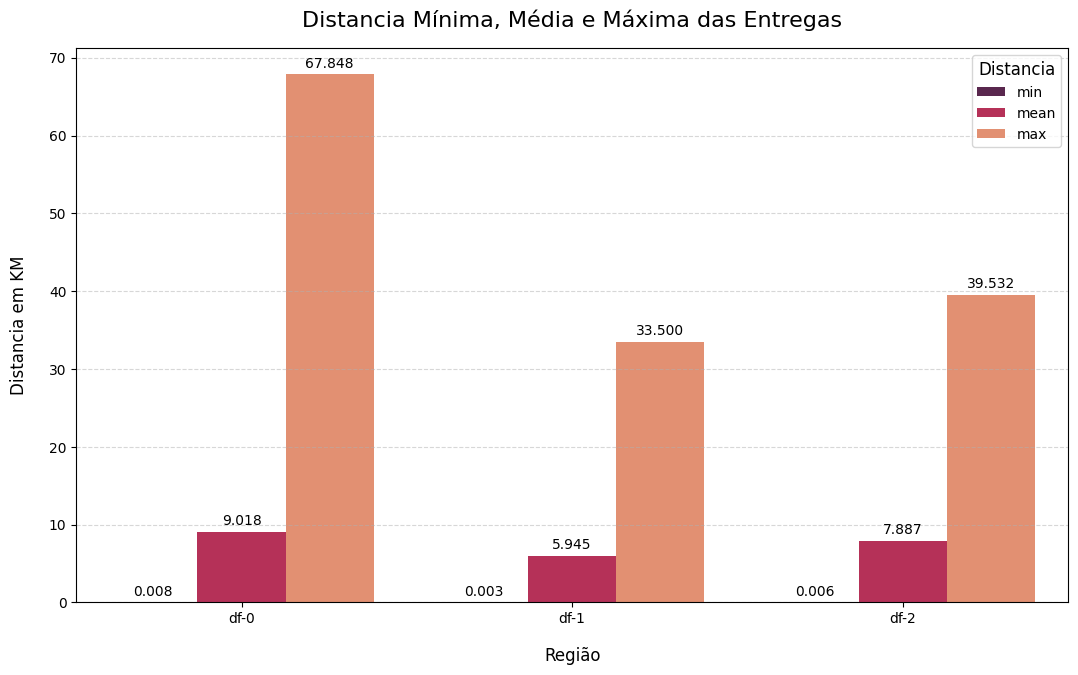

In [96]:
# Define o tamanho da figura
plt.figure(figsize=(12.8, 7.2))

# Cria o barplot com Seaborn
bar_plot2 = sns.barplot(data=min_mean_max_long_df, x='region', y='distance', hue='measure', palette='rocket')

# Adiciona valores em cima das colunas.
for p in bar_plot2.containers:
    bar_plot2.bar_label(p, fmt='%.3f', label_type='edge', padding=3)

# Muda a escala do gráfico para os valores menores ficar mais visivel.
#plt.yscale('log')

# Adicionar título e rótulos e legenda.
plt.title('Distancia Mínima, Média e Máxima das Entregas', fontsize=16, pad=15)
plt.xlabel('Região', fontsize=12, labelpad=15)
plt.ylabel('Distancia em KM', fontsize=12, labelpad=15)
bar_plot2.get_legend().set_title('Distancia', prop={'size': 12})

# Adiciona Linhas no gráfico.
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Exibe o gráfico.
plt.show()

In [110]:
delivery_size_df = pd.DataFrame(deliveries_df.groupby('region')['delivery_size'].value_counts()).reset_index()
delivery_size_df.head()

,region,delivery_size,count
0,df-0,4,7255
1,df-0,5,7146
2,df-0,6,7146
3,df-0,10,7086
4,df-0,2,7060


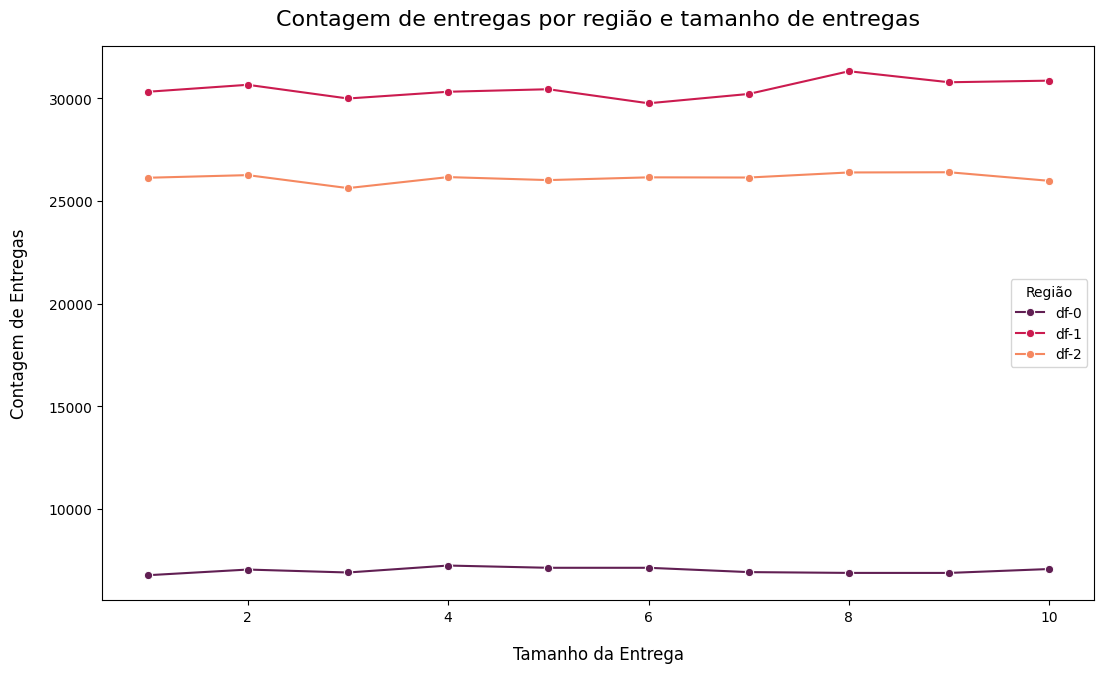

In [144]:
# Define o tamanho do gráfico.
plt.figure(figsize=(12.8, 7.2))

# Cria o Lineplot com Seaborn.
sns.lineplot(data=delivery_size_df, x='delivery_size', y='count', hue='region', palette='rocket', marker='o')

# Adicionar título e rótulos e legenda.
plt.title('Contagem de entregas por região e tamanho de entregas', fontsize=16, pad=15)
plt.xlabel('Tamanho da Entrega', fontsize=12, labelpad=15)
plt.ylabel('Contagem de Entregas', fontsize=12, labelpad=15)
plt.legend(title='Região')

# Exibe o gráfico
plt.show()